In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import collections, math

import matplotlib.pyplot as plt
%matplotlib inline 

In [11]:
#crop test images by detections_full_AGNOSTICnms.pkl 取同类中score最高的，按类的数量加权平均
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_resnet101_rfcn_ohem_iter_30000.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.5
outputs = []
count = np.zeros(len(detections_full_AGNOSTICnms))

for im in range(len(detections_full_AGNOSTICnms)):
    if im%1000 == 0:
        print(im)
    detects_im = detections_full_AGNOSTICnms[im]
    score_max = np.max(detects_im[:,5:], axis=1)
    inds = np.argmax(detects_im[:,5:], axis=1)
    labels = [FISH_CLASSES[ind+1] for ind in inds]
    columns = ['box1', 'box2', 'box3', 'box4']
    columns.extend(FISH_CLASSES)
    detects_im_df = pd.DataFrame(detects_im, columns=columns)
    detects_im_df['max_cls'] = labels
    detects_im_df['max_score'] = score_max
    detects_im_df = detects_im_df[detects_im_df["max_score"]>=CONF_THRESH]  
    detects_im_df['Counts'] = detects_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = detects_im_df.groupby(['max_cls'])['max_score'].transform(max) == detects_im_df['max_score']
    detects_im_df = detects_im_df[idx]
    detects_im_array = detects_im_df[columns].as_matrix()
    count[im] = detects_im_array.shape[0]
    if detects_im_array.shape[0] == 0:
        ind = np.argmax(score_max)
        outputs_im = detects_im[ind, :]
    else:
        outputs_im = detects_im_array
    outputs.append(outputs_im)

print(sum([outputs[i].shape[0] for i in range(len(outputs))]))

0
1000
2000
3000
4000
11835


In [12]:
count5 = count

In [13]:
collections.Counter(count)

Counter({0.0: 636, 1.0: 4079, 2.0: 62})

In [17]:
np.where(count==2)[0][-10:]
#np.ndarray.tolist(np.where(count==2)[0][:10])

array([2782, 2809, 2944, 3332, 3570, 3615, 3794, 3877, 4056, 4407])

In [ ]:
diff = [(count5[i]-count9[i])>0 and count9[i]!=0 for i in range(4777)]
ims_diff = []
for i in range(1,2):
    if diff[i] == True:
        ims_diff.append(i)

ims_diff

[[  2.06798126e+02   1.64827972e+02   5.08387604e+02   3.09646118e+02
    9.78190656e-05   9.99863863e-01   2.22195231e-05   3.54365497e-08
    1.80513069e-07   1.53803467e-05   8.32632310e-08   3.57639891e-07]
 [  8.64530090e+02   5.46821106e+02   1.12497290e+03   7.17507385e+02
    1.92074701e-01   1.95946894e-04   1.48843086e-04   7.78394096e-05
    8.03207994e-01   4.06230055e-03   1.47003535e-04   8.54286627e-05]]
[[  5.58756470e+02   7.21156006e+01   8.47744507e+02   1.97563293e+02
    6.39760401e-05   9.99904156e-01   1.39432004e-05   8.67323067e-08
    2.82419421e-07   1.67916078e-05   1.14952819e-07   5.74925821e-07]
 [  8.62533936e+02   5.46338928e+02   1.12568518e+03   7.17568298e+02
    2.02214763e-01   1.88252132e-04   1.42092045e-04   7.42238626e-05
    7.93151557e-01   4.00737859e-03   1.41531869e-04   8.02396753e-05]]
[[  3.45365540e+02   4.06838440e+02   5.47757690e+02   4.91064819e+02
    2.53742735e-04   2.17653178e-05   4.96016175e-04   8.23484297e-05
    3.88963645

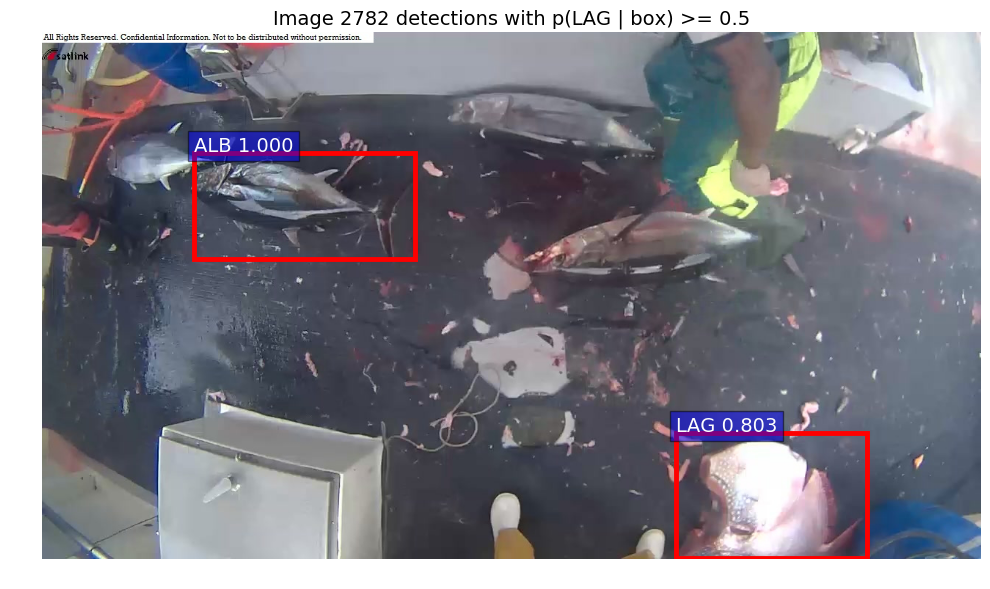

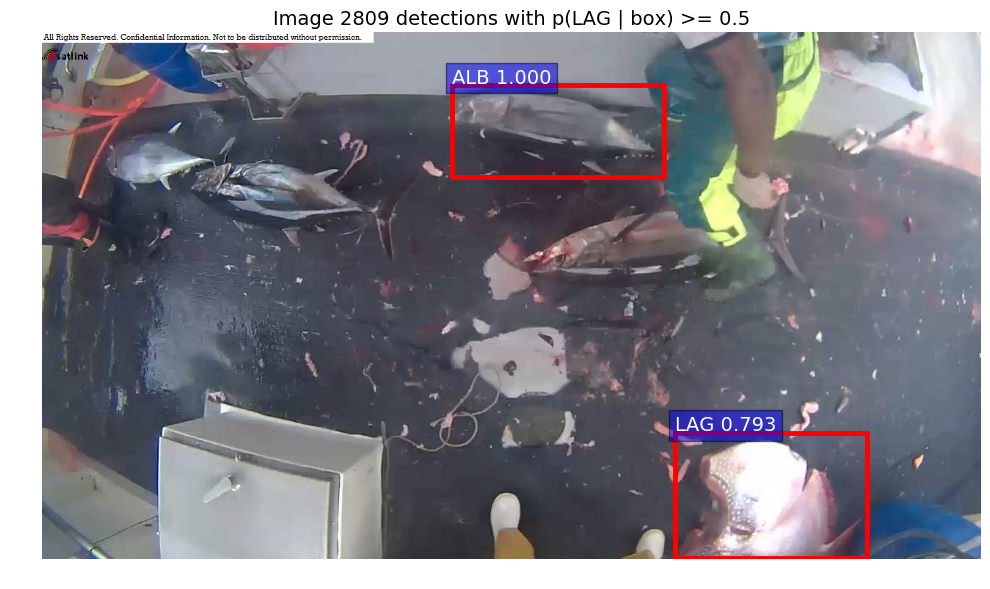

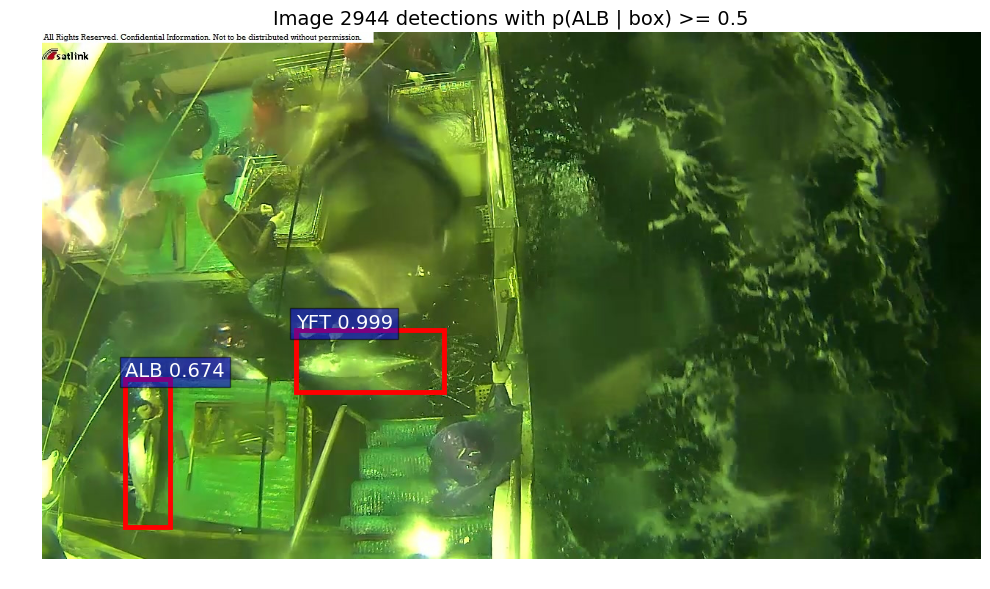

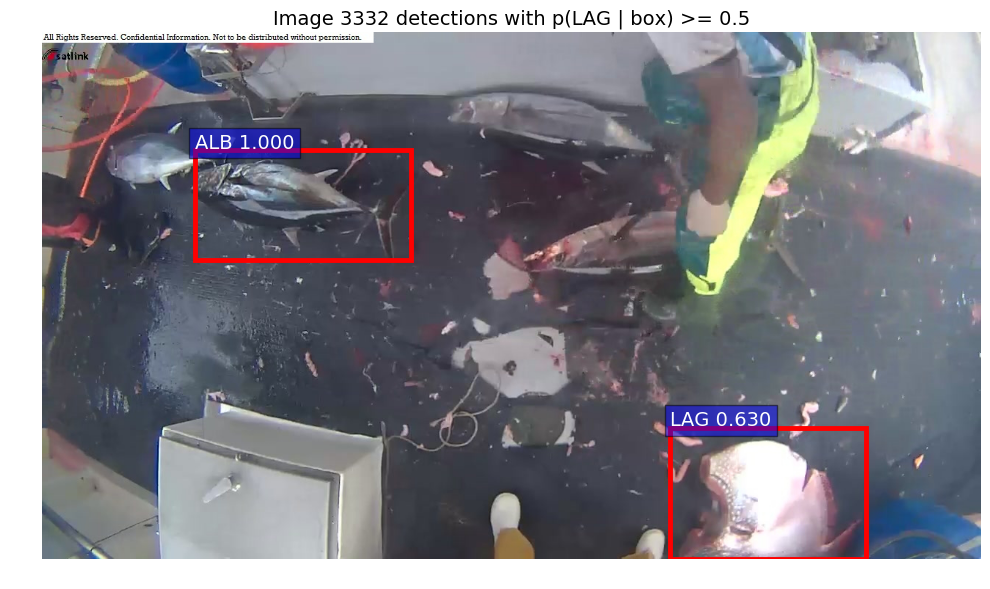

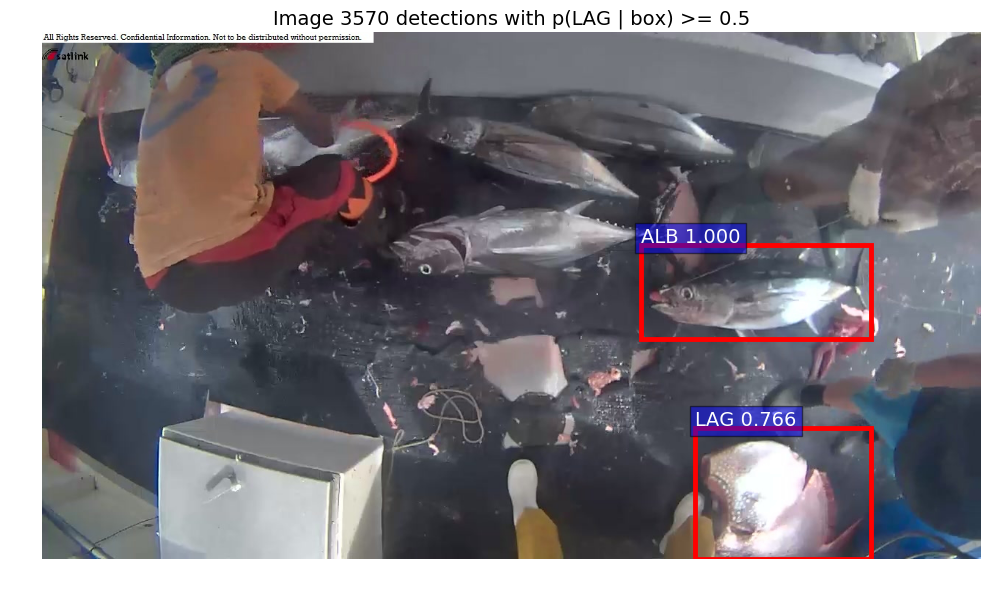

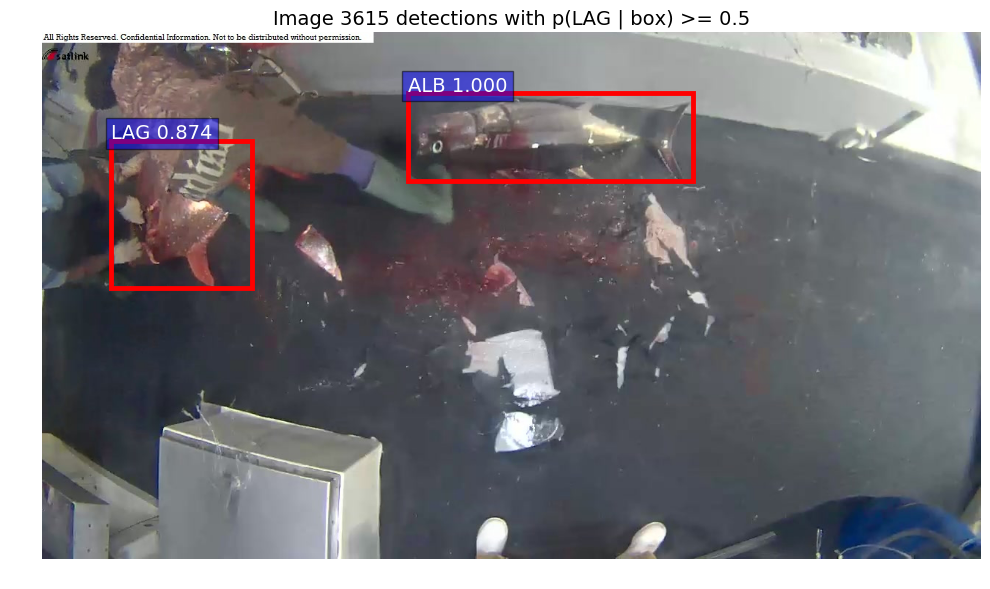

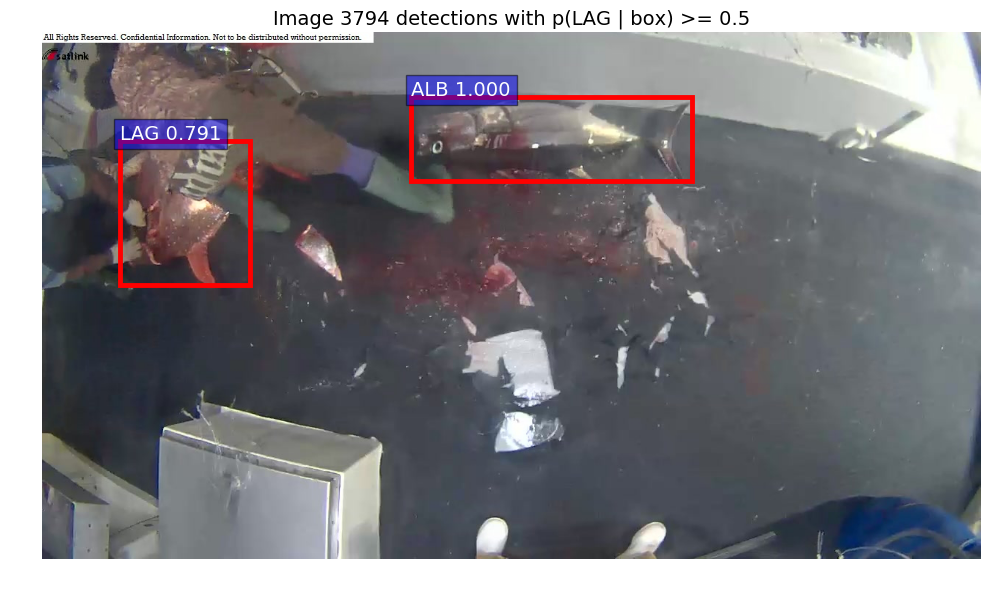

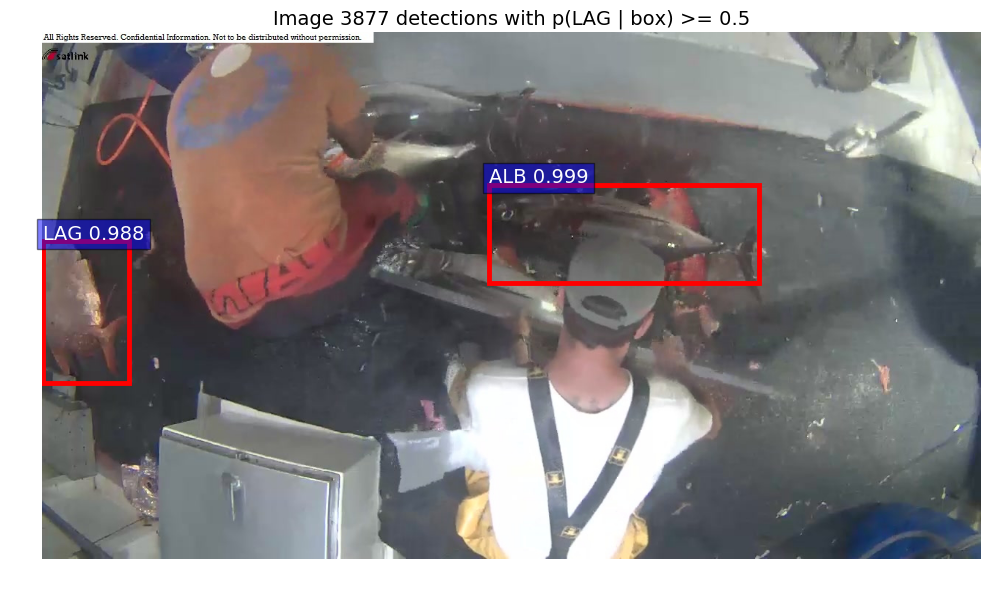

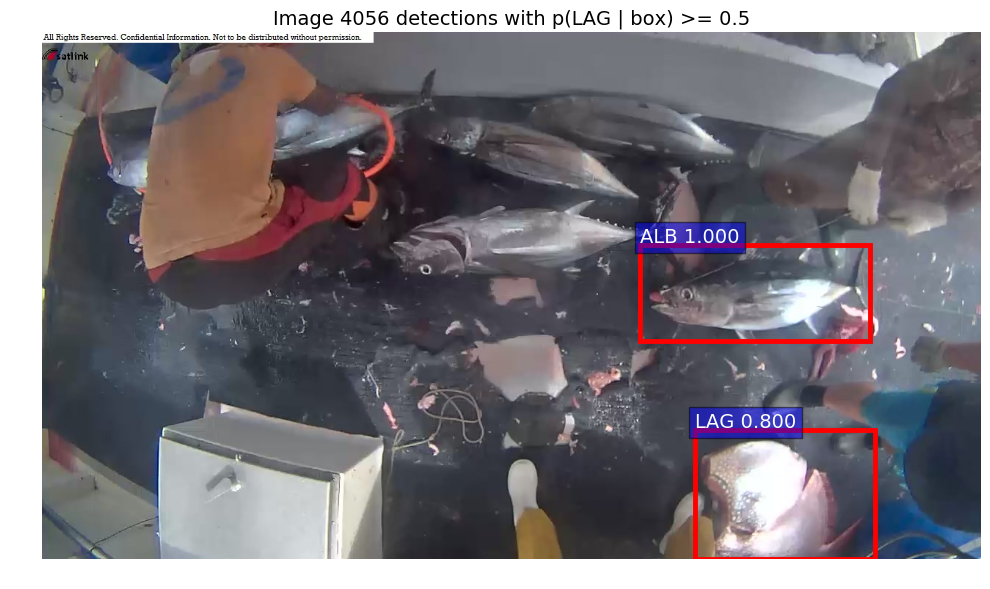

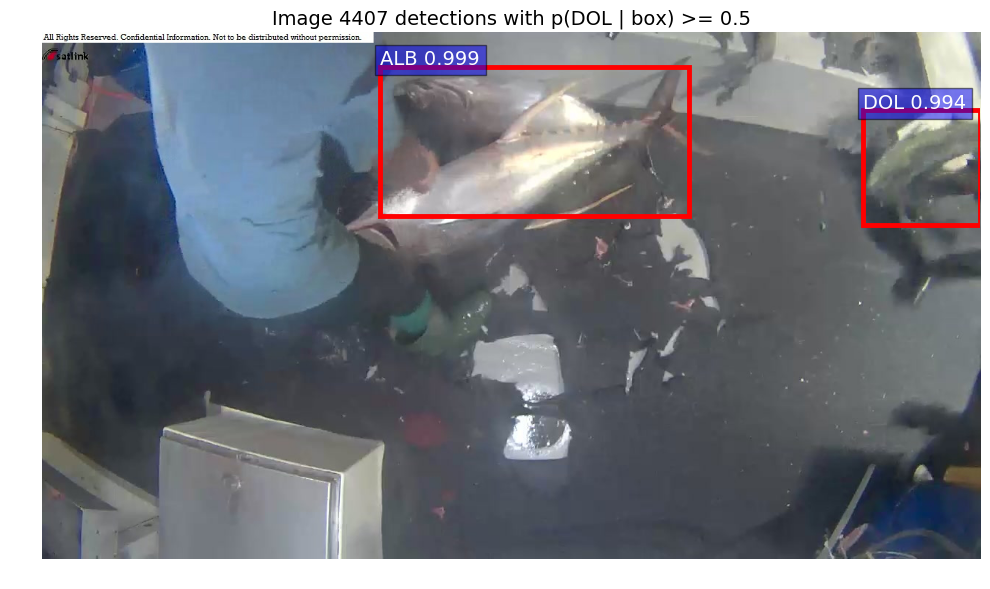

In [19]:
#visualize test image crop
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

for j in np.ndarray.tolist(np.where(count==2)[0][-10:]):
    dets = outputs[j]
    print(dets)
    im = Image.open("../RFCN/JPEGImages/"+test_files[j])
    im = np.asarray(im)
    #im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im, aspect='equal')
    for i in range(dets.shape[0]):
        bbox = dets[i, :4]
        score = np.amax(dets[i,4:])
        index = np.argmax(dets[i,4:])
        class_name = FISH_CLASSES[index]
        #if not (bbox[0] == 0 and bbox[1] == 0 and bbox[2] == 0 and bbox[3] == 0):
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5))
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('Image {} detections with '
                  'p({} | box) >= {:.1f}').format(j, class_name, CONF_THRESH),fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [3]:
#submission from detections_full_AGNOSTICnms.pkl 取同类中score最高的，按类的数量加权平均
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

import pickle 
with open('../data/RFCN_detections/detections_full_AGNOSTICnms_resnet101_rfcn_ohem_iter_20000.pkl','rb') as f:
    detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    
CONF_THRESH = 0.8
outputs = np.ndarray((len(detections_full_AGNOSTICnms), len(FISH_CLASSES)), dtype=np.float64)

for im in range(len(detections_full_AGNOSTICnms)):
    if im%1000 == 0:
        print(im)
    detects_im = detections_full_AGNOSTICnms[im]
    score_max = np.max(detects_im[:,5:], axis=1)
    inds = np.argmax(detects_im[:,5:], axis=1)
    labels = [FISH_CLASSES[ind+1] for ind in inds]
    columns = ['box1', 'box2', 'box3', 'box4']
    columns.extend(FISH_CLASSES)
    detects_im_df = pd.DataFrame(detects_im, columns=columns)
    detects_im_df['max_cls'] = labels
    detects_im_df['max_score'] = score_max
    detects_im_df = detects_im_df[detects_im_df["max_score"]>=CONF_THRESH]  
    detects_im_df['Counts'] = detects_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = detects_im_df.groupby(['max_cls'])['max_score'].transform(max) == detects_im_df['max_score']
    detects_im_df = detects_im_df[idx]
    l = FISH_CLASSES.copy()
    l.append('Counts')
    detects_im_array = detects_im_df[l].as_matrix()
    if detects_im_array.shape[0] == 0:
        ind = np.argmax(score_max)
        outputs_im = detects_im[ind,4:12]
    else:
        outputs_im = np.average(detects_im_array[:,:-1], axis=0, weights=detects_im_array[:,-1], returned=False)
    outputs[im] = outputs_im
    


0
1000
2000
3000
4000
logloss of train is 0.15553628739262249


In [17]:
# CLIP_THRESH = 0.02
# outputs_cliped = np.clip(outputs, CLIP_THRESH, 1, out=None)
# outputs_cliped = outputs_cliped/np.sum(outputs_cliped, axis=1, keepdims=True)
# test_preds = outputs_cliped[:1000]
# train_preds = outputs_cliped[1000:]

#temperature
T = 2
outputs_T = np.exp(np.log(outputs)/T)
outputs_T = outputs_T/np.sum(outputs_T, axis=1, keepdims=True)
test_preds = outputs_T[:1000]
train_preds = outputs_T[1000:]


with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims[:1000]]
train_files = [im[:-1] for im in ims[1000:]]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

log_losses = []
for i in range(len(train_preds)):
    im = train_files[i]
    for im_label in train_file_labels:
        if im == im_label[:9]:
            label = im_label[10:-1]
            index = FISH_CLASSES.index(label)
            log_losses.append(-math.log(train_preds[i][index]))
log_loss = sum(log_losses) / float(len(log_losses))
print('logloss of train is', log_loss )

import datetime

submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
#submission.loc[:, 'image'] = pd.Series(test_files, index=submission.index)
submission.insert(0, 'image', test_files)

now = datetime.datetime.now()
# info = 'RFCN_AGONOSTICnms_clsMaxAve_resnet101_rfcn_ohem_iter_20000_conf{:.1f}_'.format(CONF_THRESH) + 'clip{:.2f}_'.format(CLIP_THRESH) + '{:.4f}'.format(log_loss)
info = 'RFCN_AGONOSTICnms_clsMaxAve_resnet101_rfcn_ohem_iter_20000_T{}_'.format(T) + 'clip{:.2f}_'.format(CLIP_THRESH) + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

logloss of train is 0.12131812911701692


In [14]:
np.min(outputs_T)

9.2826364840979444e-05

([array([  66.,  737.,  854.,  776.,  583.,  349.,  206.,  133.,  113.,
           69.,   55.,   43.,   31.,   23.,    9.,   21.,   11.,   18.,
            7.,    4.,    7.,    7.,    6.,    4.,    4.,    2.,    1.,
            2.,    0.,    0.,    2.,    1.,    1.,    0.,    1.,    0.,
            3.,    1.,    1.,    2.,    3.,    0.,    0.,    1.,    1.,
            3.,    3.,    2.,    1.,    2.,    2.,    3.,    5.,    5.,
            1.,    2.,    1.,    4.,    4.,    1.,    1.,    1.,    1.,
            1.,    3.,    0.,    6.,    4.,    5.,    5.,    3.,    6.,
            1.,    3.,    5.,    1.,    3.,    4.,    5.,    7.,    4.,
            7.,    3.,    4.,    5.,    4.,    8.,   10.,   11.,    8.,
            9.,   11.,   18.,   19.,   21.,   32.,   26.,   44.,   89.,  182.]),
  array([  1.20000000e+03,   4.86000000e+02,   2.49000000e+02,
           1.30000000e+02,   1.04000000e+02,   5.80000000e+01,
           5.00000000e+01,   2.50000000e+01,   2.10000000e+01,
          

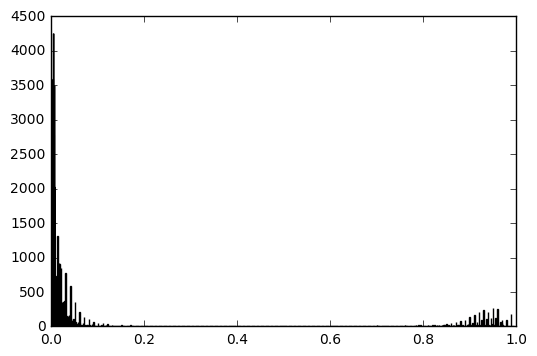

In [16]:
plt.hist(outputs_T, bins=100)